In [2]:
import Tranceiver_ADRV9009_DataCollection as txvr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

### Chirp Params:

Set the chirp params here.  F_center is the center frequency of the chirp.  B_chirp is the chirp bandwidth.  And T_chirp is the duration.  Make sure to either have F_LO overlap or F_center be within the bandwidth (F_LO -124.5 MHz, F_LO + 124.5MHz).

In [9]:
F_center = 1250e6 #1228.8e6
B_chirp = 10e6
T_chirp = 10e-6

### Data Generation Params

These params have to do with generating an ideal chirp and putting into the tranceiver design.  TX_sample rate is the sample rate of the tranceiver, 153.6MHz corresponds to the MGT Frequency of the Si570 Clock and 40 - the lane rate.  TX_N_Samples is the number of samples the ideal chirp will consist of - which is constant and based on the design. There are 8192 to 32 to bit values in the bram but since the tranceiver looks at increments of 40 bits - the first 32 bits at address 0x0 and then the bottom 8 bits at address 0x1 -  the bram size is only 4096 * 40 bits.  The tx_bram_filename is the name of the file that must then be loaded onto the zcu102 and run with load_bram.c, to activate the tranceiver with new data.

In [10]:
TX_sample_rate = 153.6*40e6
TX_N_samples = 8192*40
tx_bram_filename = "tx_bram.txt"

### Data Collection Params

These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [11]:
RX_sample_rate = 245.76e6
F_LO = 1250e6
RX_N_sample = 1024*1024

### HDF5

These params initialize the hdf5 class.  The hdf5_datafile is the name of the file where all the chirp data collected later in this script will be saved.  Collect_HDF5() is initalized by the hdf5_datafile and gets an object used later to access hdf5 methods.  Since running the hdf5 collection can be time consuming I added hdf5_save_en which allows to omit saving chirp data.

In [12]:
hdf5_datafile = 'adrv9009_phase_tests.hdf5'
hdf5_save = txvr.Collect_HDF5(hdf5_datafile = hdf5_datafile)
hdf5_save_en = False

### Make a chirp and plot the ideal response

Sample rate of the transeiver: 6.144 GHz, Number of Samples in TXBRAM: 4096*40 bits, Center frequency of the chirp: 700MHz, Bandiwdth Chirp 30MHz, Time Duration Chirp 20 us, file name to scp to zcu102/adrv9009 tx_bram.txt

In [83]:
ideal_chirp = txvr.generate_ideal_chirp(F_sample = TX_sample_rate, N_sample = TX_N_samples, F_center = F_center, B_chirp = B_chirp, T_chirp = T_chirp, text_name = tx_bram_filename)

In [84]:
df_ideal_chirp_params = hdf5_save.make_df_from_object_params(ideal_chirp)

In [85]:
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_chirp_params, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_params")

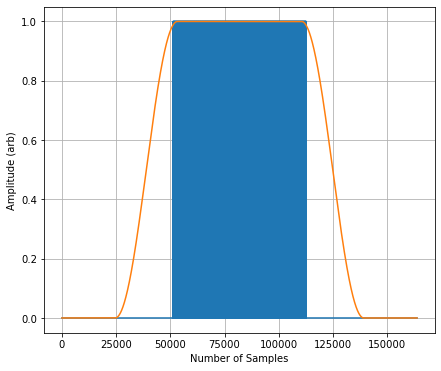

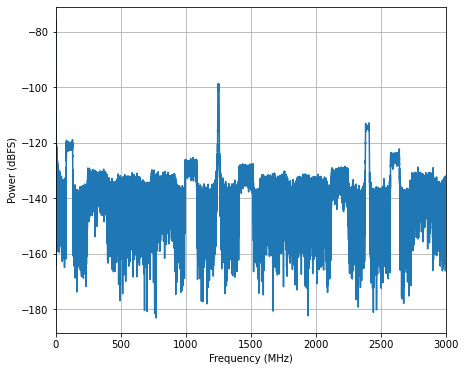

In [86]:
f_ideal, R_ideal, x_data = ideal_chirp.make_ideal_chirp()

In [63]:
if(hdf5_save_en == True):
    # Save ideal data dataframe and cast to np.int16 
    df_ideal_data = pd.DataFrame(x_data).astype(np.int16)

    # Save ideal data dataframe to the hdf5 file
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_data, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_Data")

# After this scp tx_bram.txt to the zcu102/adrv9009 OS
Run load_tx_bram.c from SDK.

### Configure the ADRV9009 Receiver

This class sets the params in the ADRV9009 receiver.  The rx bandwidth of the ADRV9009 defaults to 245.76 MHz, so make sure that the LO frequency is set near the chirp center frequency in the ideal chirp.  Here I have set them to 700 MHz.

ip is: ip:192.168.1.21, LO frequency of the receiver is 700 MHz, RX gain is 25dB, Rx Buffer Size is the number of samples to collect: 32768, TX Gain is not relevent now: -14dB, Calibration not enabled here.

In [64]:
adrv9009_config = txvr.ADRV9009_Config_1(ip = "ip:192.168.1.21", f_lo = F_LO, rx_gain = 25, rx_buffer_size = RX_N_sample,
                 tx_gain = -14, calibrate_rx_phase_correction_en = 0, calibrate_rx_qec_en = 0, calibrate_tx_qec_en = 0, 
                 calibrate = 1)

In [65]:
if(hdf5_save_en == True):
    df_adrv9009_config_params = hdf5_save.make_df_from_object_params(adrv9009_config)
    hdf5_save.save_df_to_hdf5(df_in = df_adrv9009_config_params, hdf5_datafile = hdf5_datafile, title = "ADRV9009_Data_Collection_params")

### Chirp Phase Analysis

Get data from the ADRV9009

In [66]:
data = adrv9009_config.get_ADC_data_Read()

make dataframe from data

In [67]:
df_data = pd.DataFrame(data)

In [68]:
if(hdf5_save_en == True):
    raw_data_array = hdf5_save.complex128_to_complexint(df_in = df_data)
    hdf5_save.save_array_data_to_hdf5(nparray_in = raw_data_array, title = "Raw_Data")

Subtract F_Center from LO to get the offset of the chirp with respect to the ADRV9009 receiver

In [69]:
F_cent = F_center - F_LO

Extract Chirp Params 

In [70]:
K_chirp = B_chirp/T_chirp
M_sample = len(data)

Create a Frequency array based on the length of the data and the ADRV9009 sample rate

In [71]:
f = np.arange(-M_sample/2,M_sample/2)/M_sample*RX_sample_rate

Pulse compress the data

In [72]:
Z = np.fft.fftshift(scipy.fftpack.fft(np.fft.fftshift(data)))*np.exp(1j*np.pi*(f-F_cent)**2/K_chirp)/np.sqrt(1j)
z = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(Z)))

Get max of my sinc function z for plotting

In [73]:
z_max = max(abs(z))

Plot some data

C:\software\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


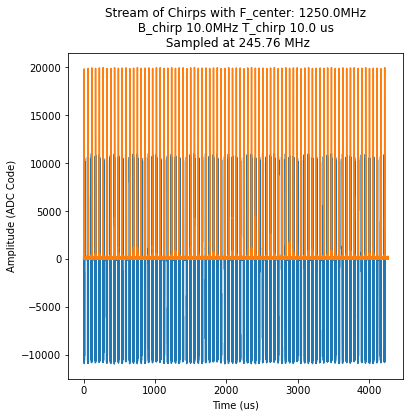

In [74]:
plt.figure(figsize = (6,6))
plt.title("Stream of Chirps with F_center: " + str(F_center/1e6) + "MHz\n B_chirp " + str(B_chirp/1e6) + "MHz T_chirp " + str(T_chirp*1e6) + " us \n Sampled at " + str(RX_sample_rate/1e6) +" MHz")
plt.xlabel("Time (us)")
plt.ylabel("Amplitude (ADC Code)")
plt.plot(np.arange(0,M_sample)/RX_sample_rate*1e6, data)
plt.plot(np.arange(0,M_sample)/RX_sample_rate*1e6, abs(z)/z_max*20000, label = "pulse compressed")
plt.show()

Plot zoomed in

C:\software\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


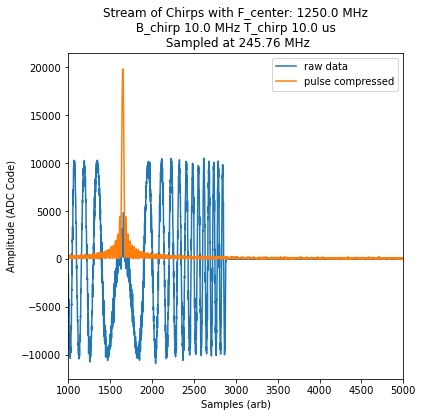

In [75]:
plt.figure(figsize = (6,6))
plt.title("Stream of Chirps with F_center: " + str(F_center/1e6) + " MHz\n B_chirp " + str(B_chirp/1e6) + " MHz T_chirp " + str(T_chirp*1e6) + " us \n Sampled at " + str(RX_sample_rate/1e6) +" MHz")
plt.xlabel("Samples (arb)")
plt.ylabel("Amplitude (ADC Code)")
plt.xlim(1000,5000)
plt.plot(data, label = "raw data")
plt.plot(abs(z)/z_max*20000, label = "pulse compressed")
plt.legend()
plt.show()

C:\software\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


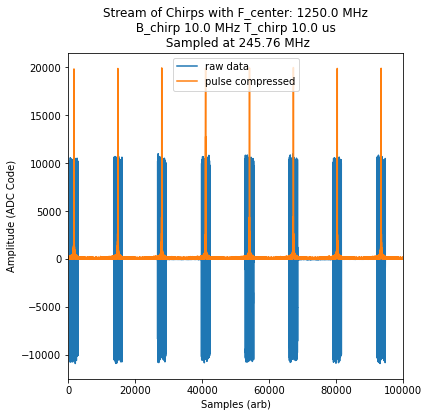

In [76]:
plt.figure(figsize = (6,6))
plt.title("Stream of Chirps with F_center: " + str(F_center/1e6) + " MHz\n B_chirp " + str(B_chirp/1e6) + " MHz T_chirp " + str(T_chirp*1e6) + " us \n Sampled at " + str(RX_sample_rate/1e6) +" MHz")
plt.xlabel("Samples (arb)")
plt.ylabel("Amplitude (ADC Code)")
plt.xlim(0, 100000)
plt.plot(data, label = "raw data")
plt.plot(abs(z)/z_max*20000, label = "pulse compressed")
plt.legend()
plt.show()

Use find_peaks to extract peaks from the data, I set the height arbitrarily here and the distance according to the expected chirp duration.  chirp_loc is the index in units of samples that the peak of the sinc function occurs and amplitude is the corresponding amplitude.

In [77]:
chirp_loc, amplitude = scipy.signal.find_peaks(z, height = 5000, distance = int(T_chirp*RX_sample_rate))
chirp_loc

C:\software\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([   1651,   14792,   27863,   40971,   54113,   67185,   80293,
         93435,  106506,  119616,  132687,  145828,  158936,  172078,
        185150,  198259,  211330,  224471,  237579,  250652,  263793,
        276901,  290043,  303114,  316224,  329295,  342436,  355544,
        368616,  381758,  394867,  407938,  421079,  434187,  447329,
        460401,  473509,  486651,  499722,  512832,  525973,  539044,
        552152,  565224,  578366,  591475,  604546,  617687,  630795,
        643937,  657009,  670117,  683189,  696330,  709440,  722511,
        735652,  748760,  761832,  774974,  788082,  801154,  814295,
        827403,  840545,  853617,  866725,  879867,  892938,  906046,
        919119,  932260,  945368,  958510,  971582,  984690,  997762,
       1010903, 1024012, 1037082], dtype=int64)

Get the length of the array.  The BRAM memory is 4096 x 40-bits / 6144Mbps = 26.667us. So if you put a 10us chirp in memory, the repeat time in the captured data will be 26.667us.

In [78]:
Chirps_in_data = len(chirp_loc)
Chirps_in_data

80

Not sure this makes sense since I've configured the ADRV9009 buffer to be RX_N_sample = 1024 x 1024 = 10488576

In [79]:
Expected_chirps = RX_N_sample/RX_sample_rate/26.667e-6
Expected_chirps

159.9980000249997

Overlap vertical lines to see that the peak finder seems to work

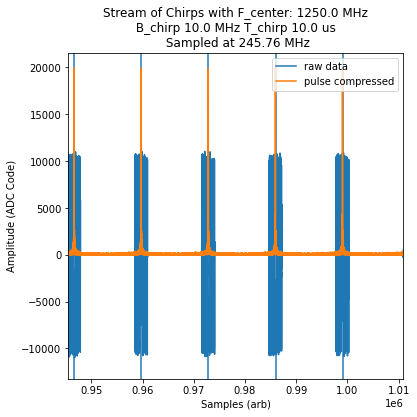

In [34]:
plt.figure(figsize = (6,6))
plt.title("Stream of Chirps with F_center: " + str(F_center/1e6) + " MHz\n B_chirp " + str(B_chirp/1e6) + " MHz T_chirp " + str(T_chirp*1e6) + " us \n Sampled at " + str(RX_sample_rate/1e6) +" MHz")
plt.xlabel("Samples (arb)")
plt.ylabel("Amplitude (ADC Code)")
plt.plot(data, label = "raw data")
plt.xlim(945502,1010905)
for elem in chirp_loc:
    plt.axvline(x = elem)
plt.plot(abs(z)/z_max*20000, label = "pulse compressed")
plt.legend()
plt.show()

Look at the difference in time of subsequent chirps and put in a list

In [35]:
chirp_loc_diff_time = [(chirp_loc[i] - chirp_loc[i-1])/RX_sample_rate*1e6 for i in range(1,len(chirp_loc))]

Plot the difference in time of subsequent chirps in histogram

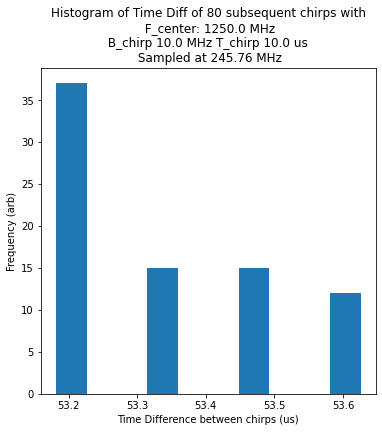

In [36]:
plt.figure(figsize = (6,6))
plt.hist(chirp_loc_diff_time)
plt.title("Histogram of Time Diff of " + str(len(chirp_loc)) + " subsequent chirps with\n F_center: " + str(F_center/1e6) + " MHz\n B_chirp " + str(B_chirp/1e6) + " MHz T_chirp " + str(T_chirp*1e6) + " us \n Sampled at " + str(RX_sample_rate/1e6) +" MHz")
plt.xlabel("Time Difference between chirps (us)")
plt.ylabel("Frequency (arb)")
plt.savefig("chirp_time_diff_hist.pdf")
plt.show()

Use the peak of the sinc functions z to extract phase from the raw data data

In [37]:
chirp_phase = [np.angle(data[elem], deg = True) for elem in chirp_loc]

Plot phase vs time 

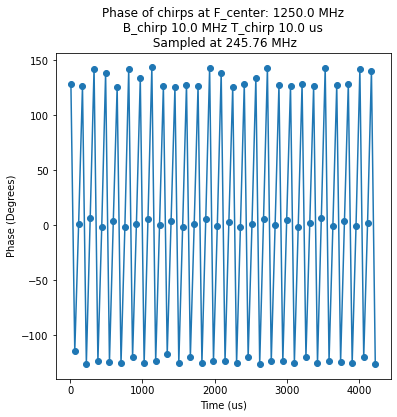

In [38]:
plt.figure(figsize = (6,6))
plt.title("Phase of chirps at F_center: " + str(F_center/1e6) + " MHz\n B_chirp " + str(B_chirp/1e6) + " MHz T_chirp " + str(T_chirp*1e6) + " us \n Sampled at " + str(RX_sample_rate/1e6) +" MHz")
plt.ylabel("Phase (Degrees)")
plt.xlabel("Time (us)")
plt.plot(chirp_loc/RX_sample_rate*1e6, chirp_phase, '-o')
plt.savefig("chirp_phase.pdf")
plt.show()

In [39]:
pd.DataFrame(data).to_csv("Data_for_phase_measurement.csv")

### Davids Matlab Script

In [3]:
df = pd.read_csv("Data_for_phase_measurement.csv")

In [4]:
data = df['0'].to_numpy()

In [5]:
data = np.complex128(data)

In [6]:
data

array([ -2. +2.j,  -4.+20.j, -27.-17.j, ...,  -1.+21.j,  36. +7.j,
         5. -1.j])

In [13]:
t = np.arange(-RX_N_sample/2,RX_N_sample/2)/RX_sample_rate

In [14]:
f = np.arange(-RX_N_sample/2,RX_N_sample/2)/RX_N_sample*RX_sample_rate

In [18]:
F_cent = 0
K_chirp = B_chirp/T_chirp

In [19]:
X = np.fft.fftshift(scipy.fftpack.fft(np.fft.fftshift(data)))
Y = X*np.exp(1j*np.pi*(f-F_cent)**2/K_chirp)/np.sqrt(1j)
y = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(Y)))

In [20]:
len(f)

1048576

In [21]:
y_max = max(abs(y))

In [22]:
T_pri = TX_N_samples/TX_sample_rate

In [23]:
T_pri

5.333333333333333e-05

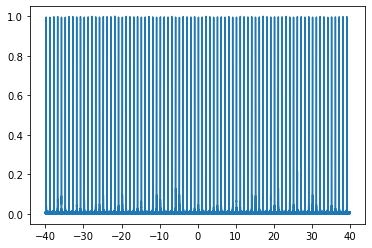

In [24]:
plt.plot(t/T_pri, abs(y)/y_max)
plt.show()

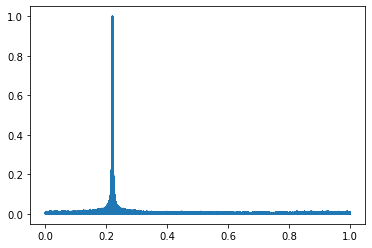

In [25]:
plt.plot(np.mod(t/T_pri,1), abs(y)/y_max)
plt.show()

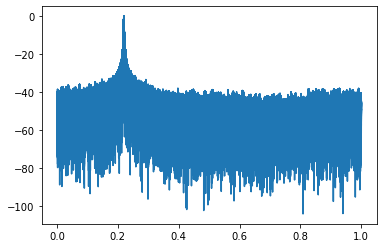

In [26]:
plt.plot(np.mod(t/T_pri,1), 20*np.log10(abs(y)/y_max))
plt.show()

In [27]:
N_pulses = int(np.floor(RX_N_sample/RX_sample_rate/T_pri))

In [28]:
N_pulse = int(2*np.ceil(RX_N_sample/N_pulses/2))

In [29]:
n = np.argmax(abs(y[:N_pulse]))
m = max(abs(y[:N_pulse]))

In [30]:
n_offset = n+N_pulse/2

In [31]:
T_offset = n_offset/RX_sample_rate

In [32]:
X =  np.fft.fftshift(scipy.fftpack.fft(data))

In [34]:
z = np.zeros((N_pulses, N_pulse))


In [69]:
z = []
i = 0

In [70]:
X_shift = X*np.exp(1j*2*np.pi*f*T_offset + 1j*2*np.pi*f*i*T_pri)
x_shift = np.fft.ifft(np.fft.fftshift(X_shift))
z.append(x_shift[:N_pulse])

In [71]:
X_shift[0]

(-90399.00000005089+18740.999999754535j)

In [74]:
x_shift[2]

(10.000000000163226+8.000000000462592j)

In [75]:
len(x_shift)

1048576

In [76]:
z

[array([26.-15.j, 23.-10.j, 10. +8.j, ..., 12.+38.j, 13.+29.j,  8.+43.j])]

In [77]:
for i in range(N_pulses):
    X_shift = X*np.exp(1j*2*np.pi*f*T_offset + 1j*2*np.pi*f*i*T_pri)
    x_shift = np.fft.ifft(np.fft.fftshift(X_shift))
    z.append(x_shift[:N_pulse])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [78]:
z = np.array(z)

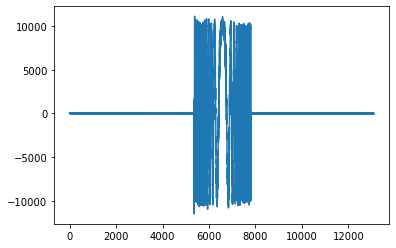

In [274]:
plt.plot(z[1])
plt.show()

In [98]:
t = np.arange(-N_pulse/2, N_pulse/2)/RX_sample_rate
f = np.arange(-N_pulse/2, N_pulse/2)/N_pulse*RX_sample_rate

In [99]:
len(t)

13108

In [86]:
z_pc = []
Z_pc = []

In [88]:
for i in range(N_pulses-1):
    Z_pc.append(np.fft.fftshift(scipy.fftpack.fft(np.fft.fftshift(z[i])))*np.exp(1j*np.pi*(f-F_cent)**2/K_chirp)/np.sqrt(1j))
    z_pc.append(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(Z_pc[i]))))

In [94]:
z_pc = np.array(z_pc)
Z_pc = np.array(Z_pc)

In [104]:
z_norm = max(abs(z_pc[0]));

In [105]:
len(z_pc)

79

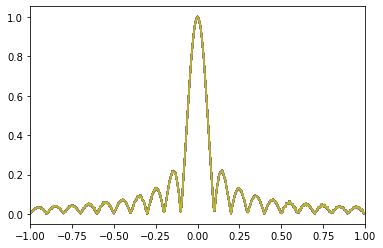

In [106]:
plt.xlim(-1,1)
for i in range(len(z_pc)):
    plt.plot(t*1e6, abs(z_pc[i])/z_norm)
plt.show()

In [150]:
z_norm = max(abs(z_pc[0]))

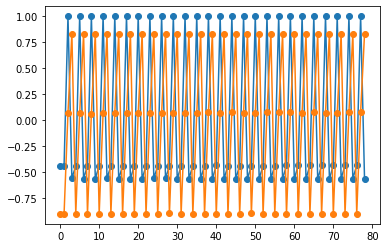

In [153]:
plt.plot(np.real(pd.DataFrame(z_pc/z_norm)[int(N_pulse/2)]), '-o')
plt.plot(np.imag(pd.DataFrame(z_pc/z_norm)[int(N_pulse/2)]), '-o')
plt.show()

In [158]:
a = pd.DataFrame(z_pc)[int(N_pulse/2)]

In [159]:
a = a/z_norm

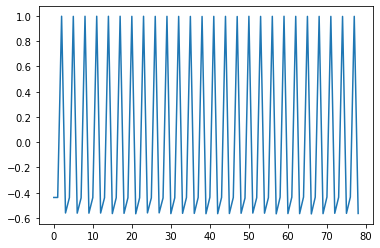

In [160]:
plt.plot(a)
plt.show()

In [156]:
pd.DataFrame(z_pc)[int(N_pulse/2)]

0    -0.437330-0.899301j
1    -0.437330-0.899301j
2     0.997330+0.067687j
3    -0.560101+0.830303j
4    -0.438237-0.898003j
             ...        
74    0.995881+0.075815j
75   -0.563136+0.827996j
76   -0.434081-0.900489j
77    0.996451+0.078547j
78   -0.563878+0.826633j
Name: 6554, Length: 79, dtype: complex128

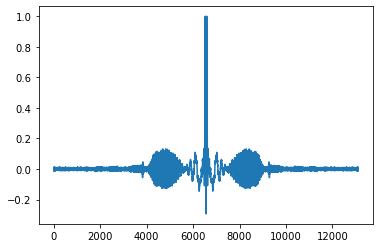

In [288]:
plt.plot(z_pc[0]/z_norm)
plt.show()

In [292]:
N_pulse

13108

In [294]:
n

2849

In [226]:
t = np.arange(-N_pulse/2, N_pulse/2)/RX_sample_rate
f = np.arange(-N_pulse/2, N_pulse/2)/N_pulse*RX_sample_rate

In [217]:
N_pulse

13108

In [221]:
x_shift[:N_pulse]

array([-33.00000004+16.00000008j, -12.99999957 +1.99999912j,
         6.99999988+23.99999812j, ...,   3.9999999  -8.00000003j,
        26.00000084-17.99999919j,  -2.00000007-24.00000028j])

In [198]:
T_offset

3.338623046875e-05

In [205]:
z[0]

array([0., 0., 0., ..., 0., 0., 0.])

array([-33.00000004+16.00000008j, -12.99999957 +1.99999912j,
         6.99999988+23.99999812j, ...,   3.9999999  -8.00000003j,
        26.00000084-17.99999919j,  -2.00000007-24.00000028j])

In [212]:
N_pulses

80